# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from tensorflow.keras.layers import * 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import keras
import numpy
import pandas as pd
import matplotlib.pyplot as plt

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r'/content/drive/My Drive/mhist_dataset')  # Change the directory to the project folder in your drive

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
mnist_train

<BatchDataset element_spec=(TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>

# Model creation

In [ ]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential([Conv2D(filters=32, 
                           kernel_size=(3,3), 
                           strides=1, 
                           padding='same',
                           activation='relu',
                           input_shape=(28,28,1)),

                    MaxPool2D(pool_size=(2, 2), strides=1),

                    Conv2D(filters=64, 
                           kernel_size=(3,3), 
                           strides=1, 
                           padding='same',
                           activation='relu'),

                   MaxPool2D(pool_size=(2, 2), strides=2),
                   Flatten(),
                   Dropout(rate=0.5),
                   Dense(units=128, activation='relu'),
                   Dropout(rate=0.5),
                   Dense(units=10, activation='linear')])



# Build fully connected student.
fc_model = tf.keras.Sequential([Flatten(),
                                Dense(units=784, activation='relu'),
                                Dense(units=784, activation='relu'),
                                Dense(units=10, activation='linear')])


# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  
  loss=tf.keras.losses.CategoricalCrossentropy(axis=-1,name='categorical_crossentropy')
  cross_entropy_loss_value = loss(labels,tf.nn.softmax(subclass_logits, axis=-1))


  return cross_entropy_loss_value

# Student loss function

In [ ]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 8. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA=0.9, DISTILLATION_TEMPERATURE=8. ):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value =distillation_loss(teacher_subclass_logits,student_subclass_logits, DISTILLATION_TEMPERATURE )

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  loss=tf.keras.losses.CategoricalCrossentropy(axis=-1,name='categorical_crossentropy')
  cross_entropy_loss_value = loss(labels,tf.nn.softmax(student_subclass_logits, axis=-1))

  return (ALPHA*  distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value) 

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.math.reduce_sum(tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0] 
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


In [ ]:
def train_and_evaluate_student(model, compute_loss_fn, ALPHA=0.9, DISTILLATION_TEMPERATURE=8. ):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0] 
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

# Training models

In [ ]:
# your code start from here for step 5 
#teacher training
train_and_evaluate(cnn_model,compute_teacher_loss)


Epoch 1: Class_accuracy: 97.81%
Epoch 2: Class_accuracy: 98.57%
Epoch 3: Class_accuracy: 98.92%
Epoch 4: Class_accuracy: 98.86%
Epoch 5: Class_accuracy: 98.92%
Epoch 6: Class_accuracy: 99.09%
Epoch 7: Class_accuracy: 99.17%
Epoch 8: Class_accuracy: 99.10%
Epoch 9: Class_accuracy: 99.09%
Epoch 10: Class_accuracy: 99.17%
Epoch 11: Class_accuracy: 99.26%
Epoch 12: Class_accuracy: 99.15%


In [ ]:
#use this to reinitilize the student model for training
fc_model = tf.keras.Sequential([Flatten(),
                                Dense(units=784, activation='relu'),
                                Dense(units=784, activation='relu'),
                                Dense(units=10, activation='linear')])

In [ ]:
ALPHA = 0.8 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 8. #temperature hyperparameter
train_and_evaluate_student(fc_model,compute_student_loss,ALPHA, DISTILLATION_TEMPERATURE)

Epoch 1: Class_accuracy: 96.66%
Epoch 2: Class_accuracy: 97.76%
Epoch 3: Class_accuracy: 98.02%
Epoch 4: Class_accuracy: 98.35%
Epoch 5: Class_accuracy: 98.40%
Epoch 6: Class_accuracy: 98.44%
Epoch 7: Class_accuracy: 98.55%
Epoch 8: Class_accuracy: 98.59%
Epoch 9: Class_accuracy: 98.57%
Epoch 10: Class_accuracy: 98.63%
Epoch 11: Class_accuracy: 98.71%
Epoch 12: Class_accuracy: 98.78%


In [ ]:
#reinitilize the student model
# you will have to re run the student and ditilation loss functions with the new alpha and temp. 
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 8. #temperature hyperparameter
train_and_evaluate_student(fc_model,compute_student_loss,ALPHA, DISTILLATION_TEMPERATURE)

Epoch 1: Class_accuracy: 98.82%
Epoch 2: Class_accuracy: 98.76%
Epoch 3: Class_accuracy: 98.84%
Epoch 4: Class_accuracy: 98.82%
Epoch 5: Class_accuracy: 98.85%
Epoch 6: Class_accuracy: 98.78%
Epoch 7: Class_accuracy: 98.87%
Epoch 8: Class_accuracy: 98.77%
Epoch 9: Class_accuracy: 98.81%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.89%


In [ ]:
#reinitilize the student model
# you will have to re run the student and ditilation loss functions with the new alpha and temp. 
ALPHA = 0.9 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 8. #temperature hyperparameter
train_and_evaluate_student(fc_model,compute_student_loss,ALPHA, DISTILLATION_TEMPERATURE)

Proceeding further we use the model trained with the hyperparameters- ALPHA= 0.8 and DISTILLATION_TEMPERATURE=8


# Test accuracy vs. temperature curve

In [ ]:
# your code start from here for step 6
temps=[1,2,4,16,32,64]
ALPHA=0.5
accuracy=[]
for i in range(6):
  fc_model = tf.keras.Sequential([Flatten(),
                                Dense(units=784, activation='relu'),
                                Dense(units=784, activation='relu'),
                                Dense(units=10, activation='linear')])
  DISTILLATION_TEMPERATURE=temps[i]
  train_and_evaluate_student(fc_model,compute_student_loss,ALPHA, DISTILLATION_TEMPERATURE)
  num_correct = 0
  num_total = builder.info.splits['test'].num_examples
  print('Case 1:')
  for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(fc_model,images,labels)[0] 
  print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
  accuracy.append(num_correct / num_total * 100)

In [ ]:
#ploting Test accuracy vs. tempreture curve
plt.plot(temps, accuracy)
plt.title('Test accuracy vs. tempreture curve')
plt.xlabel('Temperture')
plt.ylabel('Accuracy')
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([Flatten(),
                                Dense(units=784, activation='relu'),
                                Dense(units=784, activation='relu'),
                                Dense(units=10, activation='linear')])

# your code start from here for step 7



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  #print(student_subclass_logits[0])
  #print(labels[0])
  loss=tf.keras.losses.CategoricalCrossentropy(axis=-1,name='categorical_crossentropy')
  cross_entropy_loss = loss(labels,tf.nn.softmax(student_subclass_logits, axis=-1))
  #print(cross_entropy_loss)
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.44%
Epoch 2: Class_accuracy: 97.50%
Epoch 3: Class_accuracy: 98.06%
Epoch 4: Class_accuracy: 98.14%
Epoch 5: Class_accuracy: 98.19%
Epoch 6: Class_accuracy: 97.89%
Epoch 7: Class_accuracy: 97.65%
Epoch 8: Class_accuracy: 97.90%
Epoch 9: Class_accuracy: 98.20%
Epoch 10: Class_accuracy: 98.09%
Epoch 11: Class_accuracy: 97.87%
Epoch 12: Class_accuracy: 98.19%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
import numpy as np

def get_flops(model):
 
  forward_pass = tf.function(model.call,input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is important since `profile` counts multiply and accumulate as two flops
  # We have calculated the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  # Calculate no. of model parameters including trainable and non-trainable parameters
  trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
  nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
  totalParams = trainableParams + nonTrainableParams

  return flops,trainableParams,nonTrainableParams,totalParams

In [ ]:
#Calculating FLOPs and no. of parameters for the teacher model

flops_teacher,teacher_trainableParams,teacher_nonTrainableParams,teacher_totalParams = get_flops(cnn_model)
print('Flops for teacher model: {:,}'.format(flops_teacher))
print('Total Parameters for teacher model: {:,}'.format(teacher_totalParams))

Flops for teacher model: 15,152,677
Total Parameters for teacher model: 1,404,682.0


In [ ]:
#Calculating FLOPs and no. of parameters for the student model 

flops_student,student_trainableParams,student_nonTrainableParams,student_totalParams = get_flops(fc_model)
print('Flops for student model: {:,}'.format(flops_student))
print('Total Parameters for student model: {:,}'.format(student_totalParams))

Flops for teacher model: 1,237,941
Total Parameters for student model: 1,238,730.0


# XAI method to explain models

## Saliency Map using Vanilla Gradients Explanations

In [ ]:
class SaliencyMap():
    def __init__(self, model):
        """Constructs a Vanilla Gradient Map by computing dy/dx.

        Args:
            model: The TensorFlow model used to evaluate Gradient Map.
                model takes image as input and outputs probabilities vector.
        """
        self.model = model


    def get_top_predicted_idx(self, image):
        """Outputs top predicted class for the input image.

        Args:
            img_processed: numpy image array in NHWC format, pre-processed according
                to the defined model standard.

        Returns:
            Index of the top predicted class for the input image.
        """
        preds = self.model.predict(image)
        top_pred_idx = tf.argmax(preds[0])
        return top_pred_idx


    def get_gradients(self, image):
        """Computes the gradients of outputs w.r.t input image.

        Args:
            image: numpy image array in NHWC format, pre-processed according
                to the defined model standard.

        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        image = tf.convert_to_tensor(image)
        top_pred_idx = self.get_top_predicted_idx(image)

        with tf.GradientTape() as tape:
            tape.watch(image)
            preds = self.model(image)
            top_class = preds[:, top_pred_idx]

        grads = tape.gradient(top_class, image)
        return grads


    def norm_grad(self, grad_x):
        """Normalizes gradient to the range between 0 and 1
        (for visualization purposes).

        Args:
            grad_x: numpy gradients array.

        Returns:
            Gradients of the predictions w.r.t image (same shape as input image)
        """
        abs_grads = np.abs(grad_x)
        grad_max_ = np.max(abs_grads, axis=3)[0]
        arr_min, arr_max  = np.min(grad_max_), np.max(grad_max_)
        normalized_grad = (grad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
        normalized_grad = normalized_grad.reshape(1,grad_x.shape[1],grad_x.shape[2],1)

        return normalized_grad

In [ ]:
#Obtaining sample image
sample_test = np.expand_dims(images[0].numpy(),axis=0)

#Generating Saliency Map Explanation for Teacher Model 
S=SaliencyMap(cnn_model)
norm_gradient_squeezed_final_teacher = np.squeeze(np.squeeze(S.norm_grad(S.get_gradients(sample_test)),axis=3),axis=0)


#Generating Saliency Map Explanation for Student Model with KD
S=SaliencyMap(fc_model)
norm_gradient_squeezed_final_student_with_KD = np.squeeze(np.squeeze(S.norm_grad(S.get_gradients(sample_test)),axis=3),axis=0)


#Generating Saliency Map Explanation for Student Model without KD
S=SaliencyMap(fc_model_no_distillation)
norm_gradient_squeezed_final_student_without_KD = np.squeeze(np.squeeze(S.norm_grad(S.get_gradients(sample_test)),axis=3),axis=0)

(28, 28)


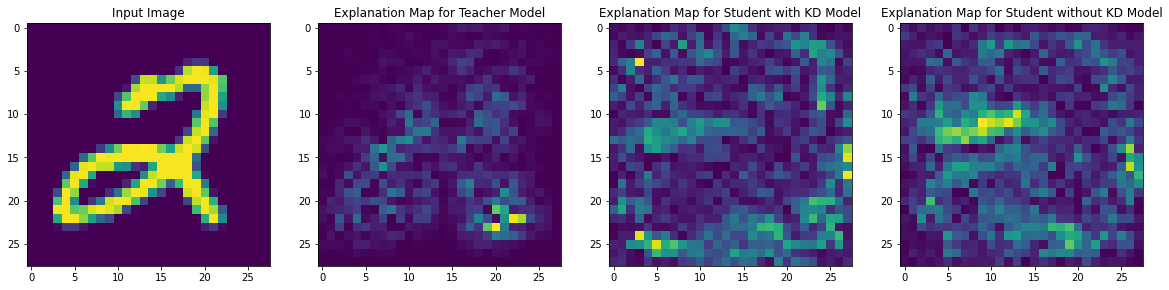

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(141)
plt.title('Input Image')
plt.imshow(images[0,:,:,0])

plt.subplot(142)
plt.imshow(norm_gradient_squeezed_final_teacher)
plt.title('Explanation Map for Teacher Model')

plt.subplot(143)
plt.imshow(norm_gradient_squeezed_final_student_with_KD)
plt.title('Explanation Map for Student with KD Model')

plt.subplot(144)
plt.imshow(norm_gradient_squeezed_final_student_without_KD)
plt.title('Explanation Map for Student without KD Model')

plt.show()

# Implementing the state-of-the-art KD algorithm using fitnets

In [ ]:
#Model Creation for student baby till the guided layer
student_baby = tf.keras.Sequential([Flatten(),
                                Dense(units=784, activation='relu'),
                                Dense(units=784, activation='relu'),
                                Dense(units=128, activation='relu')])
#Model Creation for student test incorporating student baby and the rest of the layers
student_test =  tf.keras.Sequential([student_baby,Dense(units=10, activation='linear')])

#Model Creation for teacher baby till the hint layer
teacher_baby = tf.keras.Sequential([Conv2D(filters=32, 
                           kernel_size=(3,3), 
                           strides=1, 
                           padding='same',
                           activation='relu',
                           input_shape=(28,28,1)),

                    MaxPool2D(pool_size=(2, 2), strides=1),

                    Conv2D(filters=64, 
                           kernel_size=(3,3), 
                           strides=1, 
                           padding='same',
                           activation='relu'),

                   MaxPool2D(pool_size=(2, 2), strides=2),
                   Flatten(),
                   Dropout(rate=0.5),
                   Dense(units=128, activation='relu')])


#Model Creation for teacher test incorporating student baby and the rest of the layers
teacher_test =   tf.keras.Sequential([ teacher_baby,
                                     Dropout(rate=0.5),
                                     Dense(units=10, activation='linear')])
                                                                 

In [ ]:
def compute_teacher_loss_Fitnets(images, labels):
  """Compute subclass knowledge distillation teacher baby loss for given images
     and labels.
  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = teacher_test(images, training=True)

  # Compute cross-entropy loss for subclasses.

  loss=tf.keras.losses.CategoricalCrossentropy(axis=-1,name='categorical_crossentropy')
  cross_entropy_loss_value = loss(labels,tf.nn.softmax(subclass_logits, axis=-1))
  return cross_entropy_loss_value

In [ ]:
#Calculating teacher loss with the Fitnet teacher setup
train_and_evaluate(teacher_test,compute_teacher_loss_Fitnets)

Epoch 1: Class_accuracy: 97.96%
Epoch 2: Class_accuracy: 98.30%
Epoch 3: Class_accuracy: 98.69%
Epoch 4: Class_accuracy: 98.93%
Epoch 5: Class_accuracy: 99.22%
Epoch 6: Class_accuracy: 99.08%
Epoch 7: Class_accuracy: 99.18%
Epoch 8: Class_accuracy: 99.10%
Epoch 9: Class_accuracy: 99.14%
Epoch 10: Class_accuracy: 99.06%
Epoch 11: Class_accuracy: 99.15%
Epoch 12: Class_accuracy: 99.25%


In [ ]:
student_test.build(input_shape=(None,28,28,1))
student_test.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128)               1331360   
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 1,332,650
Trainable params: 1,332,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Calculate the student L2 norm loss
def compute_student_loss_new(teacher_baby, student_baby, inp_imag):
  """
  Compute L2 norm of the outputs of these hint and guided layers 
  Args:
    images: Tensor representing a batch of images.
    teacher_baby: The TensorFlow teacher model with final layer as hint layer 
    student_baby: The TensorFlow student model with final layer as guided layer
    
  Returns:
    Scalar loss Tensor.
  """
    prediction_student_baby = student_baby(inp_imag)
    prediction_teacher_baby = teacher_baby(inp_imag)
    loss = tf.math.sqrt(tf.math.reduce_sum(tf.math.pow((prediction_teacher_baby-prediction_student_baby),2)))
    #print('loss: ',loss)
    return loss 

In [ ]:
def compute_student_loss(images, labels,teacher_baby, student_baby, ALPHA=0.9):
  """
  Compute subclass knowledge distillation student test loss using fitnets method for the given images
     and labels. Fitnets loss is calculated as the weighted sum of the L2 norm of the outputs of these hint 
     and guided layers along with the hard labels’ cross entropy loss for the student. 

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.
    teacher_baby: The TensorFlow teacher model with final layer as hint layer 
    student_baby: The TensorFlow student model with final layer as guided layer
    ALPHA: weight parameter to balance the contribution of two losses
  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = student_test(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  teacher_subclass_logits = teacher_test(images, training=False)
  distillation_loss_value = compute_student_loss_new(teacher_baby, student_baby, images)

  # Compute cross-entropy loss with hard targets.
  
  loss=tf.keras.losses.CategoricalCrossentropy(axis=-1,name='categorical_crossentropy')
  cross_entropy_loss_value = loss(labels,tf.nn.softmax(student_subclass_logits, axis=-1))
  return (ALPHA*  distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value) 

In [ ]:
def train_and_evaluate_new(teacher,student,teacher_baby,student_baby,compute_loss_fn):
  """
  Compute subclass knowledge distillation student test loss using fitnets method for the given images
     and labels. Fitnets loss is calculated as the weighted sum of the L2 norm of the outputs of these hint 
     and guided layers along with the hard labels’ cross entropy loss for the student. 

  Args:

    teacher_baby: The TensorFlow teacher model with final layer as hint layer 
    student_baby: The TensorFlow student model with final layer as guided layer
    student: The Tensorflow student model consisting of baby student followed by the classification layer 
    teacher: The TensorFlow teacher model consisting of baby teacher followed by the dropout and the classification layer
    compute_loss_fn: loss function for fitnets
  Returns:
    Prints the Epoch wise model accuracy.
  """
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_student_loss(images, labels,teacher_baby, student_baby, ALPHA=0.8)
      grads = tape.gradient(loss_value, student.trainable_variables)
      optimizer.apply_gradients(zip(grads, student.trainable_variables))
    
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += compute_num_correct(student,images,labels)[0] 
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

In [ ]:
#Calculating student loss with the Fitnets setup
train_and_evaluate_new(teacher_test,student_test,teacher_baby,student_baby, compute_student_loss)

Epoch 1: Class_accuracy: 96.09%
Epoch 2: Class_accuracy: 97.51%
Epoch 3: Class_accuracy: 98.04%
Epoch 4: Class_accuracy: 98.32%
Epoch 5: Class_accuracy: 98.42%
Epoch 6: Class_accuracy: 98.50%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.81%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.80%
Epoch 11: Class_accuracy: 98.83%
Epoch 12: Class_accuracy: 98.89%
